In [971]:
import numpy as np

class Grid:
    """Class defining a one-dimensional Cartesian grid"""
    
    def __init__(self, lx, ly, lz, ncv):
        """Constructor
            lx .... total length of domain in x-direction [m]
            ly .... total length of domain in y-direction [m]
            lz .... total length of domain in z-direction [m]
            ncv ... number of control volumes in domain
        """
        # Store the number of control volumes
        self._ncv = ncv
        
        # Calculate the control volume length
        dx = lx/float(ncv)
        
        # Calculate the face locations
        self._xf = np.array([i*dx for i in range(ncv+1)])
        
        # Calculate the cell centroid locations
        self._xP = np.array([self._xf[0]] + 
                            [0.5*(self._xf[i]+self._xf[i+1]) for i in range(ncv)] +
                            [self._xf[-1]])
        
        # Calculate face areas
        self._Af = ly*lz*np.ones(ncv+1)
        
        # Calculate the outer surface area for each cell
        self._Ao = (2.0*dx*ly + 2.0*dx*lz)*np.ones(ncv)
        
        # Calculate cell volumes
        self._vol = dx*ly*lz*np.ones(ncv)
        
    @property
    def ncv(self):
        """Number of control volumes in domain"""
        return self._ncv
    
    @property
    def xf(self):
        """Face location array"""
        return self._xf
    
    @property
    def xP(self):
        """Cell centroid array"""
        return self._xP
    
    @property
    def dx_WP(self):
        return self.xP[1:-1]-self.xP[0:-2]
        
    @property
    def dx_PE(self):
        return self.xP[2:]-self.xP[1:-1]
      
    @property
    def Af(self):
        """Face area array"""
        return self._Af

    @property
    def Aw(self):
        """West face area array"""
        return self._Af[0:-1]
    
    @property
    def Ae(self):
        """East face area array"""
        return self._Af[1:]
    
    @property
    def Ao(self):
        """Outer face area array"""
        return self._Ao
    
    @property
    def vol(self):
        """Cell volume array"""
        return self._vol

In [972]:
class ScalarCoeffs:
    """Class defining the set of coefficients for a finite-volume discretization
       of a scalar partial differential equation.
    """
    
    def __init__(self, ncv):
        """Constructor
            ncv ... number of control volumes in domain
        """
        self._ncv = ncv
        self._aP = np.zeros(ncv)
        self._aW = np.zeros(ncv)
        self._aE = np.zeros(ncv)
        self._rP = np.zeros(ncv)
        
    def zero(self):
        """Function to zero the coefficient arrays"""
        self._aP.fill(0.0)
        self._aW.fill(0.0)
        self._aE.fill(0.0)
        self._rP.fill(0.0)
        
    def accumulate_aP(self, aP):
        """Function to accumulate values onto aP"""
        self._aP += aP
        
    def accumulate_aW(self, aW):
        """Function to accumulate values onto aW"""
        self._aW += aW

    def accumulate_aE(self, aE):
        """Function to accumulate values onto aE"""
        self._aE += aE
        
    def accumulate_rP(self, rP):
        """Function to accumulate values onto rP"""
        self._rP += rP
        
    @property
    def ncv(self):
        """Number of control volumes in domain"""
        return self._ncv
        
    @property
    def aP(self):
        """Cell coefficient"""
        return self._aP
    
    @property
    def aW(self):
        """West cell coefficient"""
        return self._aW
    
    @property
    def aE(self):
        """East cell coefficient"""
        return self._aE
    
    @property
    def rP(self):
        """Cell residual"""
        return self._rP

In [973]:
from enum import Enum

class BoundaryLocation(Enum):
    """Enumeration class defining boundary condition locations"""
    WEST = 1
    EAST = 2

In [974]:
class DirichletBc:
    """Class defining a Dirichlet boundary condition"""
    
    def __init__(self, phi, grid, value, loc):
        """Constructor
            phi ..... field variable array
            grid .... grid
            value ... boundary value
            loc ..... boundary location
        """
        self._phi = phi
        self._grid = grid
        self._value = value
        self._loc = loc
        
    def value(self):
        """Return the boundary condition value"""
        return self._value
    
    def coeff(self):
        """Return the linearization coefficient"""
        return 0
    
    def apply(self):
        """Applies the boundary condition in the referenced field variable array"""
        if self._loc is BoundaryLocation.WEST:
            self._phi[0] = self._value
        elif self._loc is BoundaryLocation.EAST:
            self._phi[-1] = self._value
        else:
            raise ValueError("Unknown boundary location")

In [975]:
class NeumannBc:
    """Class defining a Neumann boundary condition"""
    
    def __init__(self, phi, grid, gradient, loc):
        """Constructor
            phi ........ field variable array
            grid ....... grid
            gradient ... gradient at cell adjacent to boundary
            loc ........ boundary location
        """
        self._phi = phi
        self._grid = grid
        self._gradient = gradient
        self._loc = loc
        
    def value(self):
        """Return the boundary condition value"""
        if self._loc is BoundaryLocation.WEST:
            return self._phi[1] - self._gradient*self._grid.dx_WP[0]
        elif self._loc is BoundaryLocation.EAST:
            return self._phi[-2] + self._gradient*self._grid.dx_PE[-1]
        else:
            raise ValueError("Unknown boundary location")
    
    def coeff(self):
        """Return the linearization coefficient"""
        return 1
    
    def apply(self):
        """Applies the boundary condition in the referenced field variable array"""
        if self._loc is BoundaryLocation.WEST:
            self._phi[0] = self._phi[1] - self._gradient*self._grid.dx_WP[0]
        elif self._loc is BoundaryLocation.EAST:
            self._phi[-1] = self._phi[-2] + self._gradient*self._grid.dx_PE[-1]
        else:
            raise ValueError("Unknown boundary location")

In [976]:
class DiffusionModel:
    """Class defining a diffusion model"""
    
    def __init__(self, grid, phi, gamma, west_bc, east_bc):
        """Constructor"""
        self._grid = grid
        self._phi = phi
        self._gamma = gamma
        self._west_bc = west_bc
        self._east_bc = east_bc
        
    def add(self, coeffs):
        """Function to add diffusion terms to coefficient arrays"""
        
        # Calculate the west and east face diffusion flux terms for each face
        flux_w = - self._gamma*self._grid.Aw*(self._phi[1:-1]-self._phi[0:-2])/self._grid.dx_WP
        flux_e = - self._gamma*self._grid.Ae*(self._phi[2:]-self._phi[1:-1])/self._grid.dx_PE
        
        # Calculate the linearization coefficients
        coeffW = - self._gamma*self._grid.Aw/self._grid.dx_WP
        coeffE = - self._gamma*self._grid.Ae/self._grid.dx_PE
        coeffP = - coeffW - coeffE
        
        # Modify the linearization coefficients on the boundaries
        coeffP[0] += coeffW[0]*self._west_bc.coeff()
        coeffP[-1] += coeffE[-1]*self._east_bc.coeff()
        
        # Zero the boundary coefficients that are not used
        coeffW[0] = 0.0
        coeffE[-1] = 0.0
        
        # Calculate the net flux from each cell
        flux = flux_e - flux_w
        
        # Add to coefficient arrays
        coeffs.accumulate_aP(coeffP)
        coeffs.accumulate_aW(coeffW)
        coeffs.accumulate_aE(coeffE)
        coeffs.accumulate_rP(flux)
        
        # Return the modified coefficient array
        return coeffs
    

In [977]:
from scipy.sparse.linalg import spsolve
from scipy.sparse import csr_matrix

def get_sparse_matrix(coeffs):
    """Function to return a sparse matrix representation of a set of scalar coefficients"""
    ncv = coeffs.ncv
    data = np.zeros(3*ncv-2)
    rows = np.zeros(3*ncv-2, dtype=int)
    cols = np.zeros(3*ncv-2, dtype=int)
    data[0] = coeffs.aP[0]
    data[1] = coeffs.aE[0]
    rows[0] = 0
    cols[0] = 0
    rows[1] = 0
    cols[1] = 1
    for i in range(ncv-2):
        data[3*i+2] = coeffs.aW[i+1]
        data[3*i+3] = coeffs.aP[i+1]
        data[3*i+4] = coeffs.aE[i+1]
        rows[3*i+2:3*i+5] = i+1
        cols[3*i+2] = i
        cols[3*i+3] = i+1
        cols[3*i+4] = i+2
    data[3*ncv-4] = coeffs.aW[-1]
    data[3*ncv-3] = coeffs.aP[-1]
    rows[3*ncv-4:3*ncv-2] = ncv-1
    cols[3*ncv-4] = ncv-2
    cols[3*ncv-3] = ncv-1
    return csr_matrix((data, (rows, cols)))

def solve(coeffs):
    """Function to solve the linear system and return the correction field"""
    # Get the sparse matrix
    A = get_sparse_matrix(coeffs)
    # Solve the linear system
    return spsolve(A, -coeffs.rP)

In [978]:
import numpy as np
from numpy.linalg import norm
# Problem1
# Define the grid
lx = 0.1
ly = 0.005
lz = 0.005
ncv = 8
grid = Grid(lx, ly, lz, ncv)

# Set the maximum number of iterations and convergence criterion
maxIter = 100
converged = 1e-6

# Define thermophysical properties
k = 60

# Define the coefficients
coeffs = ScalarCoeffs(grid.ncv)

# Initial conditions
T0 = 373

# Initialize field variable arrays
T = T0*np.ones(grid.ncv+2)

# Define boundary conditions
west_bc = DirichletBc(T, grid, 373, BoundaryLocation.WEST)
east_bc = DirichletBc(T, grid, 273, BoundaryLocation.EAST)

# Apply boundary conditions
west_bc.apply()
east_bc.apply()

# Create list to store the solutions at each iteration
T_solns = [np.copy(T)]

# Define the diffusion model
diffusion = DiffusionModel(grid, T, k, west_bc, east_bc)

# Iterate until the solution is converged
for i in range(maxIter):
    # Zero the coefficients and add each influence
    coeffs.zero()
    coeffs = diffusion.add(coeffs)

    # Compute residual and check for convergence 
    maxResid = norm(coeffs.rP, np.inf)
    avgResid = np.mean(np.absolute(coeffs.rP))
    print("Iteration = {}; Max. Resid. = {}; Avg. Resid. = {}".format(i, maxResid, avgResid))
    if maxResid < converged:
        break
    
    # Solve the sparse matrix system
    dT = solve(coeffs)
    
    # Update the solution and boundary conditions
    T[1:-1] += dT
    west_bc.apply()
    east_bc.apply()
    
    # Store the solution
    T_solns.append(np.copy(T))
    print(T)

Iteration = 0; Max. Resid. = 23.99999999999998; Avg. Resid. = 2.9999999999999973
[373.   366.75 354.25 341.75 329.25 316.75 304.25 291.75 279.25 273.  ]
Iteration = 1; Max. Resid. = 3.3306690738754696e-15; Avg. Resid. = 1.304512053934559e-15


In [979]:

#txt_file = open("GridTest.txt","a")

# Append new line
#txt_file.write('\n')

# Append your variables
#txt_file.write('ncv=' + str(ncv) + " T =" + str(T) + '\n')

# Close file
#txt_file.close()
# Storing The T values
#save_Tsolns.extend(T_solns)
#print(save_Tsolns)
#save_Tsolns = []

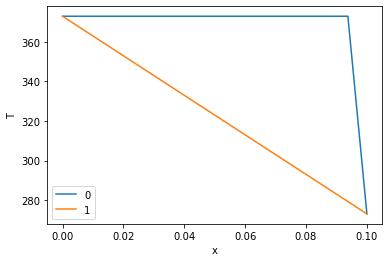

In [980]:
%matplotlib inline
import matplotlib.pyplot as plt

i = 0
for T in T_solns:
    plt.plot(grid.xP, T, label=str(i))
    i += 1

plt.xlabel("x")
plt.ylabel("T")
plt.legend()
plt.show()

In [981]:
class SurfaceConvectionModel:
    """Class defining a surface convection model"""
    
    def __init__(self, grid, T, ho, To):
        """Constructor"""
        self._grid = grid
        self._T = T
        self._ho = ho
        self._To = To
        
      
    def add(self, coeffs):
        """Function to add surface convection terms to coefficient arrays"""
        
        # Calculate the source term
        source = self._ho*self._grid.Ao*(self._T[1:-1] - self._To)
        
        # Calculate the linearization coefficients
        coeffP = self._ho*self._grid.Ao
        
        # Add to coefficient arrays
        coeffs.accumulate_aP(coeffP)
        coeffs.accumulate_rP(source)
        
        return coeffs
    

In [1057]:
# Problem 2
import numpy as np
from numpy.linalg import norm

# Define the grid
lx = 0.1
ly = 0.005
lz = 0.005
ncv = 8
grid = Grid(lx, ly, lz, ncv)

# Set the maximum number of iterations and convergence criterion
maxIter = 1000
converged = 1e-6

# Define thermophysical properties
k = 60

# Define convection parameters
ho = 12
To = 298

# Define the coefficients
coeffs = ScalarCoeffs(grid.ncv)

# Initial conditions
T0 = 373

# Initialize field variable arrays
T = T0*np.ones(grid.ncv+2)

# Added DiricheltBc at East and West Boundary Location at T = 373K
# Define boundary conditions
west_bc = DirichletBc(T, grid, 373, BoundaryLocation.WEST)
east_bc = DirichletBc(T, grid, 373, BoundaryLocation.EAST)

# Apply boundary conditions
west_bc.apply()
east_bc.apply()

# Create list to store the solutions at each iteration
T_solns = [np.copy(T)]

# Define the diffusion model
diffusion = DiffusionModel(grid, T, k, west_bc, east_bc)

# Define the surface convection model
surfaceConvection = SurfaceConvectionModel(grid, T, ho, To)

# Iterate until the solution is converged
for i in range(maxIter):
    # Zero the coefficients and add each influence
    coeffs.zero()
    coeffs = diffusion.add(coeffs)
    coeffs = surfaceConvection.add(coeffs)

    # Compute residual and check for convergence 
    maxResid = norm(coeffs.rP, np.inf)
    avgResid = np.mean(np.absolute(coeffs.rP))
    print("Iteration = {}; Max. Resid. = {}; Avg. Resid. = {}".format(i, maxResid, avgResid))
    if maxResid < converged:
        break
    
    # Solve the sparse matrix system
    dT = solve(coeffs)
    
    # Update the solution and boundary conditions
    T[1:-1] += dT
    west_bc.apply()
    east_bc.apply()
    
    # Store the solution
    T_solns.append(np.copy(T))
    print(T)

Iteration = 0; Max. Resid. = 0.225; Avg. Resid. = 0.225
[373.         369.69413636 364.8747625  361.7272577  360.17293434
 360.17293434 361.7272577  364.8747625  369.69413636 373.        ]
Iteration = 1; Max. Resid. = 1.1324274851176597e-14; Avg. Resid. = 4.107825191113079e-15


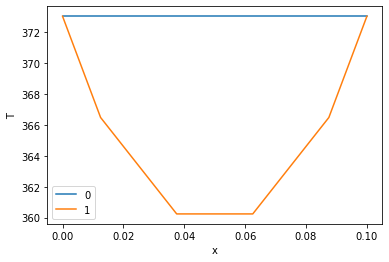

In [1055]:
%matplotlib inline
import matplotlib.pyplot as plt

i = 0
for T in T_solns:
    plt.plot(grid.xP, T, label=str(i))
    i += 1

plt.xlabel("x")
plt.ylabel("T")
plt.legend()
plt.show()
T_solns_1 = T_solns.copy()

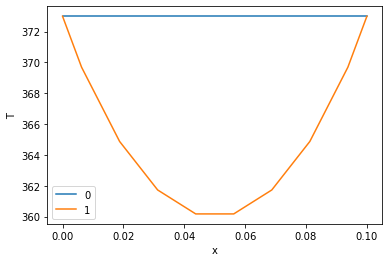

In [1058]:
%matplotlib inline
import matplotlib.pyplot as plt

i = 0
for T in T_solns:
    plt.plot(grid.xP, T, label=str(i))
    i += 1

plt.xlabel("x")
plt.ylabel("T")
plt.legend()
plt.show()
T_solns_3 = T_solns.copy()

In [1015]:
class RobinBc:
    """Class defining a Neumann boundary condition"""
    
    def __init__(self, phi, grid, T_inf, loc, ha, k):
        """Constructor
            phi ........ field variable array
            grid ....... grid
            T_inf........ Ambient Temperature
            ha is the convective heat transfer coefficient
            loc ........ boundary location
        """
        self._phi = phi
        self._grid = grid
        self._T_inf = T_inf
        self._ha = ha
        self._k = k
        self._loc = loc
        
    def value(self):
        """Return the boundary condition value"""
        if self._loc is BoundaryLocation.WEST:
            return (self._phi[1] + (self._grid.dx_WP[0]*(self._ha/self._k)*self._T_inf))/(1 + (self._grid.dx_WP[0]*(self._ha/self._k)))
        elif self._loc is BoundaryLocation.EAST:
            return ( self._phi[-2] + (self._grid.dx_PE[-1]*(self._ha/self._k)*self._T_inf))/(1 + (self._grid.dx_PE[-1]*(self._ha/self._k)))
        else:
            raise ValueError("Unknown boundary location")
    
    def coeff(self):
        """Return the linearization coefficient"""
        return 1 /(1 + (self._grid.dx_WP[0]*(self._ha/self._k)))
    
    def apply(self):
        """Applies the boundary condition in the referenced field variable array"""
        if self._loc is BoundaryLocation.WEST:
            self._phi[0] = (self._phi[1] + (self._grid.dx_WP[0]*(self._ha/self._k)*self._T_inf))/(1 + (self._grid.dx_WP[0]*(self._ha/self._k)))
        elif self._loc is BoundaryLocation.EAST:
            self._phi[-1] = ( self._phi[-2] + (self._grid.dx_PE[-1]*(self._ha/self._k)*self._T_inf))/(1 + (self._grid.dx_PE[-1]*(self._ha/self._k)))
        else:
            raise ValueError("Unknown boundary location")

In [1016]:
class HeatGenerationModel:
    """Class defining a surface convection model"""
    
    def __init__(self, grid, q):
        """Constructor"""
        self._grid = grid
        #self._ha = ha
        #self._k = k
        #self._ncv = ncv
        #dx = lx/float(ncv)
        #self._vol = dx*ly*lz*np.ones(ncv)
        self._q = q
        
    def add(self, coeffs):
        """Function to add surface convection terms to coefficient arrays"""
        
        # Calculating the source term SpVp with a negative sign to subtract it.
        source =  - self._q*self._grid.vol
        #print(source)
        
        # Calculate the linearization coefficients
        coeffP = 0
        
        # Add to coefficient arrays
        coeffs.accumulate_aP(coeffP)
        coeffs.accumulate_rP(source)
        
        return coeffs

In [1027]:
import numpy as np
from numpy.linalg import norm

# Define the grid
lx = 0.1
ly = 1
lz = 1
ncv = 32

grid = Grid(lx, ly, lz, ncv)


# Set the maximum number of iterations and convergence criterion
maxIter = 1000
converged = 1e-6

# Define thermophysical properties
k = 26

# Define convection parameters
ha = 280
q = 50000

# Define the coefficients
coeffs = ScalarCoeffs(grid.ncv)

# Initial conditions
T0 = 300

# Initialize field variable arrays
T = T0*np.ones(grid.ncv+2)

# Added DiricheltBc at East and West Boundary Location at T = 373K
# Define boundary conditions
west_bc = RobinBc(T, grid, 323, BoundaryLocation.WEST, ha, k)
east_bc = RobinBc(T, grid, 313, BoundaryLocation.EAST, ha, k)

# Apply boundary conditions
west_bc.apply()
east_bc.apply()

# Create list to store the solutions at each iteration
T_solns = [np.copy(T)]

# Define the diffusion model
diffusion = DiffusionModel(grid, T, k, west_bc, east_bc)

# Define the surface convection model
HeatGeneration = HeatGenerationModel(grid, q)

# Iterate until the solution is converged
for i in range(maxIter):
    # Zero the coefficients and add each influence
    coeffs.zero()
    coeffs = diffusion.add(coeffs)
    coeffs = HeatGeneration.add(coeffs)

    # Compute residual and check for convergence 
    maxResid = norm(coeffs.rP, np.inf)
    avgResid = np.mean(np.absolute(coeffs.rP))
    print("Iteration = {}; Max. Resid. = {}; Avg. Resid. = {}".format(i, maxResid, avgResid))
    if maxResid < converged:
        break
    
    # Solve the sparse matrix system
    dT = solve(coeffs)
    
    # Update the solution and boundary conditions
    T[1:-1] += dT
    west_bc.apply()
    east_bc.apply()
    
    # Store the solution
    T_solns.append(np.copy(T))
    print(T)

Iteration = 0; Max. Resid. = 6489.67789598013; Avg. Resid. = 466.0372340425492
[328.67857143 328.77412431 328.94645003 329.09999571 329.23476133
 329.35074691 329.44795244 329.52637792 329.58602335 329.62688874
 329.64897407 329.65227936 329.6368046  329.60254979 329.54951494
 329.47770003 329.38710508 329.27773008 329.14957503 329.00263994
 328.83692479 328.6524296  328.44915436 328.22709907 327.98626374
 327.72664835 327.44825292 327.15107744 326.83512191 326.50038633
 326.14687071 325.77457503 325.38349931 325.17857143]
Iteration = 1; Max. Resid. = 1.0911662684520707e-09; Avg. Resid. = 2.9958791003537044e-10


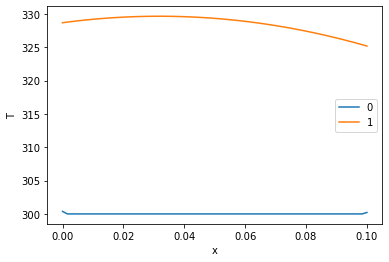

In [1028]:
%matplotlib inline
import matplotlib.pyplot as plt

i = 0
for T in T_solns:
    plt.plot(grid.xP, T, label=str(i))
    i += 1

plt.xlabel("x")
plt.ylabel("T")
plt.legend()
plt.show()

In [988]:
# Problem 4
class SurfaceRadiationModel:
    """Class defining a surface convection model"""
    
    def __init__(self, grid, T, Tc, epi, sigma):
        """Constructor"""
        self._grid = grid
        self._T = T
        self._epi = epi
        self._Tc = Tc
        self._sigma = sigma
        
    def add(self, coeffs):
        """Function to add surface convection terms to coefficient arrays"""
        
        # Calculate the source term
        source = -self._epi*self._sigma*(self._T[1:-1]**4 - self._Tc**4)
        
        # Calculate the linearization coefficients
        coeffP = 0
        
        # Add to coefficient arrays
        coeffs.accumulate_aP(coeffP)
        coeffs.accumulate_rP(source)
        
        return coeffs

In [989]:
import numpy as np
from numpy.linalg import norm

# Define the grid
lx = 0.1
ly = 0.005
lz = 0.005
ncv = 64
grid = Grid(lx, ly, lz, ncv)

# Set the maximum number of iterations and convergence criterion
maxIter = 1000
converged = 1e-6

# Define thermophysical properties
k = 60

# Define convection parameters
h = 0
epi = 1
sigma = 5.67e-8
Tc = 0

# Define the coefficients
coeffs = ScalarCoeffs(grid.ncv)

# Initial conditions
T0 = 273

# Initialize field variable arrays
T = T0*np.ones(grid.ncv+2)

# Define boundary conditions
west_bc = DirichletBc(T, grid, 373, BoundaryLocation.WEST)
east_bc = DirichletBc(T, grid, 0, BoundaryLocation.EAST)

# Apply boundary conditions
west_bc.apply()
east_bc.apply()

# Create list to store the solutions at each iteration
T_solns = [np.copy(T)]

# Define the diffusion model
diffusion = DiffusionModel(grid, T, k, west_bc, east_bc)

# Define the surface convection model
surfaceRadiation = SurfaceRadiationModel(grid, T, Tc, epi, sigma)

# Iterate until the solution is converged
for i in range(maxIter):
    # Zero the coefficients and add each influence
    coeffs.zero()
    coeffs = diffusion.add(coeffs)
    coeffs = surfaceRadiation.add(coeffs)

    # Compute residual and check for convergence 
    maxResid = norm(coeffs.rP, np.inf)
    avgResid = np.mean(np.absolute(coeffs.rP))
    print("Iteration = {}; Max. Resid. = {}; Avg. Resid. = {}".format(i, maxResid, avgResid))
    if maxResid < converged:
        break
    
    # Solve the sparse matrix system
    dT = solve(coeffs)
    
    # Update the solution and boundary conditions
    T[1:-1] += dT
    west_bc.apply()
    east_bc.apply()
    
    # Store the solution
    T_solns.append(np.copy(T))
    print(T)

Iteration = 0; Max. Resid. = 506.94422338469997; Avg. Resid. = 316.292216403928
[   373.           5619.15632725  15783.40208238  25619.58093815
  35127.69289456  44307.73795162  53159.71610931  61683.62736765
  69879.47172662  77747.24918624  85286.9597465   92498.6034074
  99382.18016894 105937.69003112 112165.13299394 118064.50905741
 123635.81822151 128879.06048626 133794.23585164 138381.34431767
 142640.38588434 146571.36055165 150174.2683196  153449.10918819
 156395.88315742 159014.59022729 161305.23039781 163267.80366896
 164902.31004076 166208.74951319 167187.12208627 167837.42775999
 168159.66653435 168153.83840935 167819.94338499 167157.98146127
 166167.95263819 164849.85691576 163203.69429396 161229.46477281
 158927.16835229 156296.80503242 153338.37481319 150051.8776946
 146437.31367665 142494.68275934 138223.98494267 133625.22022664
 128698.38861126 123443.49009651 117860.52468241 111949.49236894
 105710.39315612  99143.22704394  92247.9940324   85024.6941215
  77473.32731

<ipython-input-988-2a5c505f5d84>:17: RuntimeWarning: overflow encountered in power
  source = -self._epi*self._sigma*(self._T[1:-1]**4 - self._Tc**4)


[373.  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan
  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan
  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan
  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan
  nan  nan  nan  nan  nan  nan  nan  nan  nan   0.]
Iteration = 55; Max. Resid. = nan; Avg. Resid. = nan
[373.  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan
  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan
  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan
  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan
  nan  nan  nan  nan  nan  nan  nan  nan  nan   0.]
Iteration = 56; Max. Resid. = nan; Avg. Resid. = nan
[373.  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan
  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan
  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan
  nan  na

[373.  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan
  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan
  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan
  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan
  nan  nan  nan  nan  nan  nan  nan  nan  nan   0.]
Iteration = 120; Max. Resid. = nan; Avg. Resid. = nan
[373.  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan
  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan
  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan
  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan
  nan  nan  nan  nan  nan  nan  nan  nan  nan   0.]
Iteration = 121; Max. Resid. = nan; Avg. Resid. = nan
[373.  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan
  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan
  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan
  nan  

[373.  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan
  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan
  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan
  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan
  nan  nan  nan  nan  nan  nan  nan  nan  nan   0.]
Iteration = 190; Max. Resid. = nan; Avg. Resid. = nan
[373.  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan
  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan
  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan
  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan
  nan  nan  nan  nan  nan  nan  nan  nan  nan   0.]
Iteration = 191; Max. Resid. = nan; Avg. Resid. = nan
[373.  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan
  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan
  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan
  nan  

[373.  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan
  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan
  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan
  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan
  nan  nan  nan  nan  nan  nan  nan  nan  nan   0.]
Iteration = 235; Max. Resid. = nan; Avg. Resid. = nan
[373.  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan
  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan
  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan
  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan
  nan  nan  nan  nan  nan  nan  nan  nan  nan   0.]
Iteration = 236; Max. Resid. = nan; Avg. Resid. = nan
[373.  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan
  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan
  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan
  nan  

[373.  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan
  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan
  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan
  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan
  nan  nan  nan  nan  nan  nan  nan  nan  nan   0.]
Iteration = 295; Max. Resid. = nan; Avg. Resid. = nan
[373.  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan
  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan
  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan
  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan
  nan  nan  nan  nan  nan  nan  nan  nan  nan   0.]
Iteration = 296; Max. Resid. = nan; Avg. Resid. = nan
[373.  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan
  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan
  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan
  nan  

  nan  nan  nan  nan  nan  nan  nan  nan  nan   0.]
Iteration = 349; Max. Resid. = nan; Avg. Resid. = nan
[373.  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan
  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan
  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan
  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan
  nan  nan  nan  nan  nan  nan  nan  nan  nan   0.]
Iteration = 350; Max. Resid. = nan; Avg. Resid. = nan
[373.  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan
  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan
  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan
  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan
  nan  nan  nan  nan  nan  nan  nan  nan  nan   0.]
Iteration = 351; Max. Resid. = nan; Avg. Resid. = nan
[373.  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan
  nan  nan  nan  nan  nan  nan  nan  nan  n

  nan  nan  nan  nan  nan  nan  nan  nan  nan   0.]
Iteration = 420; Max. Resid. = nan; Avg. Resid. = nan
[373.  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan
  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan
  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan
  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan
  nan  nan  nan  nan  nan  nan  nan  nan  nan   0.]
Iteration = 421; Max. Resid. = nan; Avg. Resid. = nan
[373.  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan
  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan
  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan
  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan
  nan  nan  nan  nan  nan  nan  nan  nan  nan   0.]
Iteration = 422; Max. Resid. = nan; Avg. Resid. = nan
[373.  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan
  nan  nan  nan  nan  nan  nan  nan  nan  n

[373.  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan
  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan
  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan
  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan
  nan  nan  nan  nan  nan  nan  nan  nan  nan   0.]
Iteration = 490; Max. Resid. = nan; Avg. Resid. = nan
[373.  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan
  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan
  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan
  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan
  nan  nan  nan  nan  nan  nan  nan  nan  nan   0.]
Iteration = 491; Max. Resid. = nan; Avg. Resid. = nan
[373.  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan
  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan
  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan
  nan  

  nan  nan  nan  nan  nan  nan  nan  nan  nan   0.]
Iteration = 557; Max. Resid. = nan; Avg. Resid. = nan
[373.  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan
  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan
  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan
  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan
  nan  nan  nan  nan  nan  nan  nan  nan  nan   0.]
Iteration = 558; Max. Resid. = nan; Avg. Resid. = nan
[373.  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan
  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan
  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan
  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan
  nan  nan  nan  nan  nan  nan  nan  nan  nan   0.]
Iteration = 559; Max. Resid. = nan; Avg. Resid. = nan
[373.  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan
  nan  nan  nan  nan  nan  nan  nan  nan  n

[373.  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan
  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan
  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan
  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan
  nan  nan  nan  nan  nan  nan  nan  nan  nan   0.]
Iteration = 615; Max. Resid. = nan; Avg. Resid. = nan
[373.  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan
  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan
  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan
  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan
  nan  nan  nan  nan  nan  nan  nan  nan  nan   0.]
Iteration = 616; Max. Resid. = nan; Avg. Resid. = nan
[373.  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan
  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan
  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan
  nan  

[373.  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan
  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan
  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan
  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan
  nan  nan  nan  nan  nan  nan  nan  nan  nan   0.]
Iteration = 674; Max. Resid. = nan; Avg. Resid. = nan
[373.  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan
  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan
  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan
  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan
  nan  nan  nan  nan  nan  nan  nan  nan  nan   0.]
Iteration = 675; Max. Resid. = nan; Avg. Resid. = nan
[373.  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan
  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan
  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan
  nan  

[373.  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan
  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan
  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan
  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan
  nan  nan  nan  nan  nan  nan  nan  nan  nan   0.]
Iteration = 742; Max. Resid. = nan; Avg. Resid. = nan
[373.  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan
  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan
  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan
  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan
  nan  nan  nan  nan  nan  nan  nan  nan  nan   0.]
Iteration = 743; Max. Resid. = nan; Avg. Resid. = nan
[373.  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan
  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan
  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan
  nan  

[373.  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan
  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan
  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan
  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan
  nan  nan  nan  nan  nan  nan  nan  nan  nan   0.]
Iteration = 811; Max. Resid. = nan; Avg. Resid. = nan
[373.  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan
  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan
  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan
  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan
  nan  nan  nan  nan  nan  nan  nan  nan  nan   0.]
Iteration = 812; Max. Resid. = nan; Avg. Resid. = nan
[373.  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan
  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan
  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan
  nan  

[373.  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan
  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan
  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan
  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan
  nan  nan  nan  nan  nan  nan  nan  nan  nan   0.]
Iteration = 883; Max. Resid. = nan; Avg. Resid. = nan
[373.  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan
  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan
  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan
  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan
  nan  nan  nan  nan  nan  nan  nan  nan  nan   0.]
Iteration = 884; Max. Resid. = nan; Avg. Resid. = nan
[373.  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan
  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan
  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan
  nan  

[373.  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan
  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan
  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan
  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan
  nan  nan  nan  nan  nan  nan  nan  nan  nan   0.]
Iteration = 954; Max. Resid. = nan; Avg. Resid. = nan
[373.  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan
  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan
  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan
  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan
  nan  nan  nan  nan  nan  nan  nan  nan  nan   0.]
Iteration = 955; Max. Resid. = nan; Avg. Resid. = nan
[373.  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan
  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan
  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan
  nan  

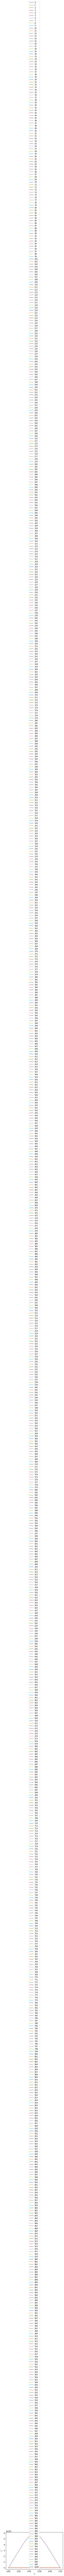

In [990]:
%matplotlib inline
import matplotlib.pyplot as plt

i = 0
for T in T_solns:
    plt.plot(grid.xP, T, label=str(i))
    i += 1

plt.xlabel("x")
plt.ylabel("T")
plt.legend()
plt.show()

In [1032]:
# Problem 4(2)
class SurfaceRadiationModel2:
    """Class defining a surface convection model"""
    
    def __init__(self, grid, T, Tc, epi, sigma):
        """Constructor"""
        self._grid = grid
        self._T = T
        self._epi = epi
        self._Tc = Tc
        self._sigma = sigma
        
    def add(self, coeffs):
        """Function to add surface convection terms to coefficient arrays"""
        
        # Calculate the source term
        source = self._epi*self._sigma*(self._T[1:-1]**4 - self._Tc**4)
        
        # Calculate the linearization coefficients
        coeffP = self._epi*self._sigma*((self._T[1:-1])**3)*4
        
        # Add to coefficient arrays
        coeffs.accumulate_aP(coeffP)
        coeffs.accumulate_rP(source)
        
        return coeffs

In [1033]:
import numpy as np
from numpy.linalg import norm

# Define the grid
lx = 0.1
ly = 0.005
lz = 0.005
ncv = 64
grid = Grid(lx, ly, lz, ncv)

# Set the maximum number of iterations and convergence criterion
maxIter = 1000
converged = 1e-6

# Define thermophysical properties
k = 60

# Define convection parameters
h = 0
epi = 1
sigma = 5.67e-8
Tc = 0

# Define the coefficients
coeffs = ScalarCoeffs(grid.ncv)

# Initial conditions
T0 = 273

# Initialize field variable arrays
T = T0*np.ones(grid.ncv+2)

# Define boundary conditions
west_bc = DirichletBc(T, grid, 373, BoundaryLocation.WEST)
east_bc = DirichletBc(T, grid, 0, BoundaryLocation.EAST)

# Apply boundary conditions
west_bc.apply()
east_bc.apply()

# Create list to store the solutions at each iteration
T_solns = [np.copy(T)]

# Define the diffusion model
diffusion = DiffusionModel(grid, T, k, west_bc, east_bc)

# Define the surface convection model
surfaceRadiation = SurfaceRadiationModel2(grid, T, Tc, epi, sigma)

# Iterate until the solution is converged
for i in range(maxIter):
    # Zero the coefficients and add each influence
    coeffs.zero()
    coeffs = diffusion.add(coeffs)
    coeffs = surfaceRadiation.add(coeffs)

    # Compute residual and check for convergence 
    maxResid = norm(coeffs.rP, np.inf)
    avgResid = np.mean(np.absolute(coeffs.rP))
    print("Iteration = {}; Max. Resid. = {}; Avg. Resid. = {}".format(i, maxResid, avgResid))
    if maxResid < converged:
        break
    
    # Solve the sparse matrix system
    dT = solve(coeffs)
    
    # Update the solution and boundary conditions
    T[1:-1] += dT
    west_bc.apply()
    east_bc.apply()
    
    # Store the solution
    T_solns.append(np.copy(T))
    #print(T)

Iteration = 0; Max. Resid. = 839.1042233847019; Avg. Resid. = 320.1342233846999
Iteration = 1; Max. Resid. = 276.4881076555913; Avg. Resid. = 101.17150650324552
Iteration = 2; Max. Resid. = 55.538990004461475; Avg. Resid. = 31.425850460282252
Iteration = 3; Max. Resid. = 16.696942908449557; Avg. Resid. = 9.644339051223831
Iteration = 4; Max. Resid. = 5.071929650074009; Avg. Resid. = 2.9496213965625575
Iteration = 5; Max. Resid. = 1.604253793593896; Avg. Resid. = 0.8867793332486957
Iteration = 6; Max. Resid. = 0.5043989648733693; Avg. Resid. = 0.2586292530389299
Iteration = 7; Max. Resid. = 0.1586124193436332; Avg. Resid. = 0.07109733331792349
Iteration = 8; Max. Resid. = 0.04270656502529176; Avg. Resid. = 0.01609723613292189
Iteration = 9; Max. Resid. = 0.004813910285349138; Avg. Resid. = 0.001682729527116956
Iteration = 10; Max. Resid. = 6.825685557778488e-05; Avg. Resid. = 2.3338616686352096e-05
Iteration = 11; Max. Resid. = 1.351919839617799e-08; Avg. Resid. = 4.557347791360215e-09


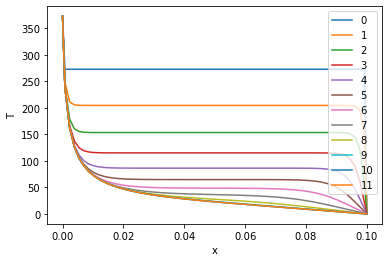

In [1034]:
%matplotlib inline
import matplotlib.pyplot as plt

i = 0
for T in T_solns:
    plt.plot(grid.xP, T, label=str(i))
    i += 1

plt.xlabel("x")
plt.ylabel("T")
plt.legend()
plt.show()